In [181]:
# Constants
IMDB_TRAIN_IMDB_BOW = "aclImdb/train/labeledBow.feat"
IMDB_TEST_IMDB_BOW = "aclImdb/test/labeledBow.feat"

MIN_WORD_FREQUENCY = 0.005
MAX_WORD_FREQUENCY = 0.5

TOP_FEATURES_BY_TF_IDF = 5000
TOP_FEATURES_BY_ABS_Z_SCORE = 100
TOP_FEATURES_BY_MI = 50

IMDB_LR = 0.01
IMDB_EPOCHS = 500
IMDB_BATCH_SIZE = 30

BERT_LR = 0.0001
BERT_EPOCHS = 3
BERT_BATCH_SIZE = 16

In [182]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import seaborn as sn


class EvaluationUtils:

    """ Utility class to evaluate models """

    @staticmethod
    def evaluate(y, y_pred):
      accuracy = sum(y_pred.argmax(axis=1) == y.argmax(axis=1))
      accuracy = accuracy / y.shape[0]
      return accuracy

    @staticmethod
    def calculate_accuracy(y_pred, y_true):
        return np.mean(np.abs(y_pred - y_true) < 1e-10)


    @staticmethod
    def calculate_bce_loss(y_probs, y_true):
        return np.mean(-1 * (y_true * np.log(y_probs + 1e-10) + (1 - y_true) * np.log(1 - y_probs + 1e-10)))

    @staticmethod
    def calculate_ce_loss(y_probs, y_true):
        return -1 * np.sum( y_true * np.log(y_probs + 1e-10) ) / len(y_true)

    @staticmethod
    def calculate_roc_auc(y_probs, y_true):
        return roc_auc_score(y_true, y_probs)


    @staticmethod
    def calculate_pr_auc(y_probs, y_true):
        precision, recall, _ = precision_recall_curve(y_true, y_probs)
        return auc(recall, precision)

    
    @staticmethod
    def plot_confusion_matrix(y_pred, y_true):
        mat = confusion_matrix(y_true, y_pred)
        df_cm = pd.DataFrame(mat)
        plt.title("Confusion Matrix")
        sn.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')

    
    @staticmethod
    def plot_roc_curve(y_probs, y_true):

        no_skill = [0 for _ in range(len(y_true))]
        ns_fpr, ns_tpr, _ = roc_curve(y_true, no_skill)
        lr_fpr, lr_tpr, _ = roc_curve(y_true, y_probs)

        ns_auc = roc_auc_score(y_true, no_skill)
        lr_auc = roc_auc_score(y_true, y_probs)

        plt.title("ROC")
        plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
        plt.plot(lr_fpr, lr_tpr, marker='.', label='Proposed Model')
        plt.grid(linewidth=0.5)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.legend()
        plt.show()


    @staticmethod
    def plot_pr_curve(y_probs, y_true):

        precision, recall, _ = precision_recall_curve(y_true, y_probs)

        plt.title("PR")
        plt.plot(recall, precision, marker='.', label='Proposed Model')
        plt.grid(linewidth=0.5)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        plt.show()

# Task 1

## IMDB (Embedding: Bag of Words)

### Download dataset

In [183]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2022-11-08 22:25:32--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.3’

aclImdb_v1.tar.gz.3 100%[===================>]  80.23M  15.2MB/s    in 9.3s    

2022-11-08 22:25:42 (8.66 MB/s) - ‘aclImdb_v1.tar.gz.3’ saved [84125825/84125825]



Unzip dataset

In [184]:
!tar -xf aclImdb_v1.tar.gz

Load dataset

Based on the documentation, the dataset include already-tokenized bag of words (BoW) features that were used in our experiments. These are stored in .feat files in the train/test directories. Each .feat file is in LIBSVM format, an ascii sparse-vector format for labeled data. The feature indices in these files start from 0, and the text tokens corresponding to a feature index is found in [imdb.vocab]. So a line with 0:7 in a .feat file means the first word in [imdb.vocab] (the) appears 7 times in that review.

In [185]:
from sklearn.datasets import load_svmlight_file
import numpy as np

# Load dataset
train_imdb_x, train_imdb_y = load_svmlight_file(IMDB_TRAIN_IMDB_BOW)
test_imdb_x, test_imdb_y = load_svmlight_file(IMDB_TEST_IMDB_BOW)

rate_score_y = train_imdb_y # Used for hypothesis testing (continuous rating scores: 1 - 10)
rate_score_y = rate_score_y.reshape(-1, 1)

print(rate_score_y.shape)

(25000, 1)


Convert to binary labels because the original label is continuous ratings (1 - 10)

In [186]:
train_imdb_y = (train_imdb_y > 5) * 1
test_imdb_y = (test_imdb_y > 5) * 1

train_imdb_y = train_imdb_y.reshape(-1, 1)
test_imdb_y = test_imdb_y.reshape(-1, 1)

print(train_imdb_y.shape)
print(test_imdb_y.shape)

(25000, 1)
(25000, 1)


### Explore Dataset

Class distributions

(50000, 1)
[0 1]
[25000 25000]


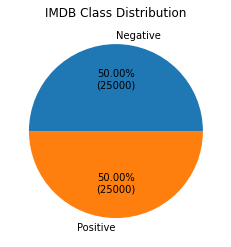

In [187]:
import matplotlib.pyplot as plt

imdb_y = np.concatenate((train_imdb_y, test_imdb_y), axis=0)
print(imdb_y.shape)

unique, counts = np.unique(imdb_y, return_counts=True)
print(unique)
print(counts)

auto_pct_func = lambda x: '{:.2f}%\n({:.0f})'.format(x, len(imdb_y) * x / 100)

labels = ["Negative", "Positive"]

plt.title("IMDB Class Distribution")
plt.pie(counts, labels=labels, autopct=auto_pct_func)
plt.show()

### Shuffle dataset

In [188]:
# Shuffle dataset
train_imdb_p = np.random.permutation(train_imdb_x.shape[0])
train_imdb_x, train_imdb_y = train_imdb_x[train_imdb_p], train_imdb_y[train_imdb_p]

print("Train & validation x: {}".format(train_imdb_x.shape))
print("Train & validation y: {}".format(train_imdb_y.shape))

test_imdb_p = np.random.permutation(test_imdb_x.shape[0])
test_imdb_x, test_imdb_y = test_imdb_x[test_imdb_p], test_imdb_y[test_imdb_p]

print("Test x: {}".format(test_imdb_x.shape))
print("Test y: {}".format(test_imdb_y.shape))

Train & validation x: (25000, 89527)
Train & validation y: (25000, 1)
Test x: (25000, 89523)
Test y: (25000, 1)


### Filter uncommon and stop words
Filter out words that appear in less than 1% of the documents and words that appear in more than 50% of the documents, which are the rare and “stopwords” respectively

In [189]:
# Calculate word frequency
total_docs = train_imdb_x.shape[0]
max_words_per_doc = train_imdb_x.shape[-1]

all_docs_word_count = np.zeros(shape=(max_words_per_doc))

low = 0
interval = 1000

# Use while loop to avoid loading values into memory all at once
while low + interval <= total_docs:
    
    high = low+interval+1
    interval_arr = (train_imdb_x[low:high]).toarray() # Convert sparse matrix to dense
    
    exists_word_mask = interval_arr > 0
    interval_docs_word_count = np.sum(exists_word_mask, axis=0)
    
    all_docs_word_count += interval_docs_word_count
    low += interval

frequency = all_docs_word_count / total_docs

print("Number of times of each word appear in documents: {}".format(all_docs_word_count))
print("Frequency of each word appear in documents: {}".format(frequency))

Number of times of each word appear in documents: [2.4816e+04 2.4184e+04 2.4196e+04 ... 1.0000e+00 1.0000e+00 1.0000e+00]
Frequency of each word appear in documents: [9.9264e-01 9.6736e-01 9.6784e-01 ... 4.0000e-05 4.0000e-05 4.0000e-05]


In [190]:
# Filter words when below MIN_WORD_FREQUENCY and above MAX_WORD_FREQUENCY
filter_words_mask = np.logical_and(frequency > MIN_WORD_FREQUENCY, frequency < MAX_WORD_FREQUENCY)
print(filter_words_mask)

keep_words_token = np.where(filter_words_mask == 1)[0]
print("Feature size after filter words: {}".format(keep_words_token.shape))

[False False False ... False False False]
Feature size after filter words: (3093,)


In [191]:
train_imdb_x = train_imdb_x[:,keep_words_token]
test_imdb_x = test_imdb_x[:,keep_words_token]

train_imdb_x = train_imdb_x.toarray()
test_imdb_x = test_imdb_x.toarray()

print("train_imdb_x after filter words: {}".format(train_imdb_x.shape))
print("test_imdb_x after filter words: {}".format(test_imdb_x.shape))

train_imdb_x after filter words: (25000, 3093)
test_imdb_x after filter words: (25000, 3093)


### Z-Score calculation, Hypothesis testing and Feature selection

Note: 

(1) We only used training set to perform hypothesis testing and feature selection

(2) We calculated the z-score of **the simple linear regression coefficient** using the following formula:

\begin{align}
z_1 = \frac{\hat{w_1}}{\sqrt{Var[\hat{w_1]}}} = \frac{\frac{1}{N}\textbf{x}^T\textbf{y}}{\sqrt{\frac{1}{N}}} = \frac{\textbf{x}^T\textbf{y}}{\sqrt{N}}
\end{align}

Standardize x and y (continuous rating score from 1 - 10)

In [192]:
def standardize(input):

    # (x - mean) / std
    mean = np.mean(input, axis=0)
    std = np.std(input, axis=0)

    return np.divide((input - mean), std)

In [193]:
import math
import copy

scaled_x = standardize(train_imdb_x)
scaled_y = standardize(rate_score_y) # Use continuous rating scores (1-10)

print(scaled_x.shape)
print(scaled_y.shape)

z_score = scaled_x.T @ scaled_y / math.sqrt(total_docs)
print("z score: {}".format(z_score))

# make a deepcopy for task 3 reporting
z_scores_imdb = copy.deepcopy(z_score)

(25000, 3093)
(25000, 1)
z score: [[-2.48819834]
 [-2.80040775]
 [ 0.18054059]
 ...
 [-1.89552877]
 [ 0.39341787]
 [-1.30144609]]


Choose top 100 features by the absolute z-score associated with continuous rating scores

In [194]:
z_score = abs(z_score[:,0])
print("Absolute z score: {}".format(z_score))

top_features = np.argsort(z_score)[:TOP_FEATURES_BY_ABS_Z_SCORE]
print("Top 100 feature index: {}".format(top_features))

Absolute z score: [2.48819834 2.80040775 0.18054059 ... 1.89552877 0.39341787 1.30144609]
Top 100 feature index: [1751 1428 2860 2297  108 2212  881 2996 1350 1479   87 2664 2663 2984
 2983  867 1518  531  223 2306 2622 1993  201 2793 3080  312 2265 1409
  686 1325 1777 1367  793 2098 1834  520 2665 1845 1332 1267 2512 2755
 2034 2353 1785 3003 1909   33 2051 1945  454 2476  168 2441 1333 2238
 1488  993 1759  810 1039  829 1839 2829 2592 2502  164 2324 1537 1517
 1635 2653 2520 2477 2834 2037 1159  366  991 1374  820 2648 1514 1793
 1999   63 1509 1971  591 1896 1169  930 1188 1219 1158 2970 2208 1956
 2977 2581]


In [195]:
train_imdb_x = train_imdb_x[:,top_features]
test_imdb_x = test_imdb_x[:,top_features]

print("train_imdb_x shape after hypothesis testing: {}".format(train_imdb_x.shape))
print("test_imdb_x shape after hypothesis testing: {}".format(test_imdb_x.shape))

train_imdb_x shape after hypothesis testing: (25000, 100)
test_imdb_x shape after hypothesis testing: (25000, 100)


### One-hot Encoding

In [196]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(train_imdb_x)

train_imdb_x = encoder.transform(train_imdb_x)
test_imdb_x = encoder.transform(test_imdb_x)

print("train_imdb_x shape after one hot encoding: {}".format(train_imdb_x.shape))
print("test_imdb_x shape after one hot encoding: {}".format(test_imdb_x.shape))

train_imdb_x shape after one hot encoding: (25000, 528)
test_imdb_x shape after one hot encoding: (25000, 528)


### Create train and validation set

In [197]:
train_imdb_x, val_imdb_x = train_imdb_x[10000:], train_imdb_x[:10000]
train_imdb_y, val_imdb_y = train_imdb_y[10000:], train_imdb_y[:10000]

print("train_imdb_x shape after hypothesis testing: {}".format(train_imdb_x.shape))
print("val_imdb_x shape after hypothesis testing: {}".format(val_imdb_x.shape))
print("train_imdb_y shape after hypothesis testing: {}".format(train_imdb_y.shape))
print("val_imdb_y shape after hypothesis testing: {}".format(val_imdb_y.shape))

train_imdb_x shape after hypothesis testing: (15000, 528)
val_imdb_x shape after hypothesis testing: (10000, 528)
train_imdb_y shape after hypothesis testing: (15000, 1)
val_imdb_y shape after hypothesis testing: (10000, 1)


## News (Embedding: TF-IDF Vectorization)

### Download dataset

In [198]:
from sklearn.datasets import fetch_20newsgroups

categories = ['comp.graphics', 'rec.sport.hockey', 'sci.med', 'soc.religion.christian']

# Train
train_news = fetch_20newsgroups(subset='train', 
                                categories=categories, 
                                shuffle=True, 
                                random_state=42,
                                remove=(['headers', 'footers', 'quotes']))

train_news_x, train_news_y = train_news.data, train_news.target

# Test
test_news = fetch_20newsgroups(subset='test',
                               categories=categories, 
                               shuffle=True, 
                               random_state=42,
                               remove=(['headers', 'footers', 'quotes']))

test_news_x, test_news_y = test_news.data, test_news.target

print("Target names:")
print(train_news.target_names)
print(test_news.target_names)

print('train_news_x length: {}'.format(len(train_news_x)))
print('train_news_y length: {}'.format(len(train_news_y)))
print('test_news_x length: {}'.format(len(test_news_x)))
print('test_news_y length: {}'.format(len(test_news_y)))

Target names:
['comp.graphics', 'rec.sport.hockey', 'sci.med', 'soc.religion.christian']
['comp.graphics', 'rec.sport.hockey', 'sci.med', 'soc.religion.christian']
train_news_x length: 2377
train_news_y length: 2377
test_news_x length: 1582
test_news_y length: 1582


### Explore Dataset

Class distributions

(3959,)
[0 1 2 3]
[973 999 990 997]


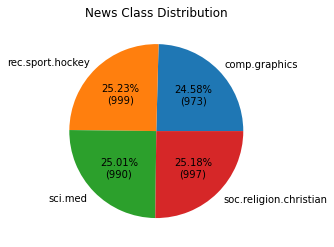

In [199]:
import matplotlib.pyplot as plt

news_y = np.concatenate((train_news_y, test_news_y), axis=0)
print(news_y.shape)

unique, counts = np.unique(news_y, return_counts=True)
print(unique)
print(counts)

auto_pct_func = lambda x: '{:.2f}%\n({:.0f})'.format(x, len(news_y) * x / 100)

plt.title("News Class Distribution")
plt.pie(counts, labels=categories, autopct=auto_pct_func)
plt.show()

### Process text (e.g. stop words, etc.)

In [200]:
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [201]:
import string

def process_text(text) -> str:

    """
    Process text
    1. Convert to lower case
    2. Remove <br />
    3. Remove punctual mark
    4. Remove stop words
    5. Remove digits
    """

    text = text.lower() # Lower case
    text = text.replace("<br />", "") # Replace <br />
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctual mark
    text_words = [w for w in text.split() if w not in stop_words and not w.isdigit()] # Remove stop words and digits

    return " ".join(text_words)

In [202]:
print("Before process:")
print(train_news_x[0])

Before process:
It is not true that dermatologists gave not reached the laser age, in
fact, lasers in dermatological surgery is a very new and exciting field.

It probably won't be effective in tinea pedis because the laser is
usually a superficial burn (to avoid any deeper damage). Limited tinea
pedis can be cured albeit sometimes slowly by topical antifungals as
well as systemic medication i.e. tablets. Finally, a self-diagnosis is
not always reliable, lichen simplex chronicus can look like a fungal
infection and requires very different treatment.


In [203]:
import copy

train_news_x = [process_text(doc) for doc in train_news_x]
test_news_x = [process_text(doc) for doc in test_news_x]

processed_train_news_x = copy.deepcopy(train_news_x)
processed_test_news_x = copy.deepcopy(test_news_x)

processed_train_news_y = copy.deepcopy(train_news_y)
processed_test_news_y = copy.deepcopy(test_news_y)

In [204]:
print("After process:")
print(train_news_x[0])

After process:
true dermatologists gave reached laser age fact lasers dermatological surgery new exciting field probably wont effective tinea pedis laser usually superficial burn avoid deeper damage limited tinea pedis cured albeit sometimes slowly topical antifungals well systemic medication ie tablets finally selfdiagnosis always reliable lichen simplex chronicus look like fungal infection requires different treatment


### Convert to feature vectors using TF-IDF (Creative Point)

In [205]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(use_idf=True, 
                                   max_features=TOP_FEATURES_BY_TF_IDF)

fitted_vectorizer = tfidf_vectorizer.fit(train_news_x)

train_news_x = fitted_vectorizer.transform(train_news_x)
test_news_x = fitted_vectorizer.transform(test_news_x)

In [206]:
print("train_news_x shape: {}".format(train_news_x.shape))
print("test_news_x shape: {}".format(test_news_x.shape))

train_news_x shape: (2377, 5000)
test_news_x shape: (1582, 5000)


In [207]:
import pandas as pd

feature_names = tfidf_vectorizer.get_feature_names()
df = pd.DataFrame((train_news_x[0]).T.todense(), index=feature_names, columns=["tfidf"]) 
df.sort_values(by=["tfidf"], ascending=False)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,tfidf
laser,0.424486
systemic,0.223883
deeper,0.223883
reached,0.214807
reliable,0.207623
...,...
fired,0.000000
fire,0.000000
finnish,0.000000
finland,0.000000


In [208]:
train_news_x = train_news_x.toarray()
test_news_x = test_news_x.toarray()

In [209]:
print("train_news_x shape: {}".format(train_news_x.shape))
print("test_news_x shape: {}".format(test_news_x.shape))

train_news_x shape: (2377, 5000)
test_news_x shape: (1582, 5000)


### Mutual information and Feature selection

In [210]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

selector = SelectKBest(mutual_info_classif, k=TOP_FEATURES_BY_MI)
fitted_selector = selector.fit(train_news_x, train_news_y)

train_news_x = fitted_selector.transform(train_news_x)
test_news_x = fitted_selector.transform(test_news_x)

In [211]:
print("train_news_x shape after MI feature selection: {}".format(train_news_x.shape))
print("test_news_x shape after MI feature selection: {}".format(test_news_x.shape))

train_news_x shape after MI feature selection: (2377, 50)
test_news_x shape after MI feature selection: (1582, 50)


### One-hot Encoding for Labels

In [212]:
from sklearn.preprocessing import OneHotEncoder

train_news_y = train_news_y.reshape(-1, 1)
test_news_y = test_news_y.reshape(-1, 1)

encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(train_news_y)

train_news_y = encoder.transform(train_news_y)
test_news_y = encoder.transform(test_news_y)

print("train_news_y shape after one hot encoding: {}".format(train_news_y.shape))
print("test_news_y shape after one hot encoding: {}".format(test_news_y.shape))

train_news_y shape after one hot encoding: (2377, 4)
test_news_y shape after one hot encoding: (1582, 4)


### Create train and validation set

In [213]:
train_news_x, val_news_x = train_news_x[:1800], train_news_x[1800:]
train_news_y, val_news_y = train_news_y[:1800], train_news_y[1800:]

print("train_news_x shape: {}".format(train_news_x.shape))
print("val_news_x shape: {}".format(val_news_x.shape))
print("train_news_y shape: {}".format(train_news_y.shape))
print("val_news_y shape: {}".format(val_news_y.shape))

train_news_x shape: (1800, 50)
val_news_x shape: (577, 50)
train_news_y shape: (1800, 4)
val_news_y shape: (577, 4)


# Task 2

In [214]:
# Please use the following variables to train IMDB dataset
# Train: train_imdb_x, train_imdb_y
# Validation: val_imdb_x, val_imdb_y
# Test: test_imdb_x, test_imdb_y

In [215]:
# Please use the following variables to train News dataset
# Train: train_news_x, train_news_y
# Validation: val_news_x, val_news_y
# Test: test_news_x, test_news_y

## Logestic Regression

### Implementation (Creative Point: Mini-batch update)

In [216]:
import numpy as np
import matplotlib.pyplot as plt

# define logistic function
logistic = lambda z: 1./ (1 + np.exp(-z))
z = np.linspace(-5,5,100)

# define logistic regression class
class LogisticRegression:

    def __init__(self, add_bias=True):
        self.add_bias = add_bias
  
    def gradient(self, x, y):
        
        N, D = x.shape
        yh = logistic(np.dot(x, self.w))
        return np.dot(x.T, yh - y) / N
    
    def fit(self, x, y, 
            x_valid, y_valid,
            batch_size=30,
            learning_rate=0.001, 
            niter=1000):
        
        total_loss_train = []
        total_loss_valid = []

        best_val_loss = float("inf")

        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack((x, np.ones(N)))
        
        N, D = x.shape
        self.w = np.zeros(D)[:,None]
        self.best_w = np.zeros(D)[:,None]
        g = np.inf

        for i in range(niter):

            batch_train_loss = []

            # Mini batch
            batch_count = int(N / batch_size)
            tot_batch_x = np.split(x, batch_count)
            tot_batch_y = np.split(y, batch_count)

            for b in range(batch_count):

                batch_x = tot_batch_x[b]
                batch_y = tot_batch_y[b]
            
                # Gradient descent
                g = self.gradient(batch_x, batch_y)
                self.w = self.w - learning_rate * g

                x_pred = batch_x[:,:-1]
                y_probs = self.predict(x_pred)
                train_loss = EvaluationUtils.calculate_bce_loss(y_probs, batch_y)
                batch_train_loss.append(train_loss)

            # Train loss
            train_loss_mean = sum(batch_train_loss) / len(batch_train_loss)
            total_loss_train.append(train_loss_mean)

            # Validation loss
            y_valid_probs = self.predict(x_valid)
            valid_loss = EvaluationUtils.calculate_bce_loss(y_valid_probs, y_valid)
            total_loss_valid.append(valid_loss)

            # Select best model weights based on validation loss
            if valid_loss < best_val_loss:
                best_val_loss = valid_loss
                self.best_w = copy.deepcopy(self.w)
                
            print("Epoch: {}, train loss: {}, validation loss: {}".format(i, train_loss, valid_loss))

        return total_loss_train, total_loss_valid

    def predict(self, x, is_test=False):
        
        if x.ndim == 1:
            x = x[:, None]
        
        if self.add_bias:
            Nt = x.shape[0]
            x = np.column_stack((x, np.ones(Nt)))

        if is_test:
            weights = self.best_w
        else:
            weights = self.w
        return logistic(np.dot(x, weights))

### Fitting the model

In [217]:
train_imdb_x_dense = train_imdb_x.toarray()
val_imdb_x_dense = val_imdb_x.toarray()
test_imdb_x_dense = test_imdb_x.toarray()

logistic_regression = LogisticRegression()
total_loss_train, total_loss_valid = logistic_regression.fit(train_imdb_x_dense, train_imdb_y, 
                                                             val_imdb_x_dense, val_imdb_y,
                                                             batch_size=IMDB_BATCH_SIZE,
                                                             learning_rate=IMDB_LR,
                                                             niter=IMDB_EPOCHS)

Epoch: 0, train loss: 0.6941871400491876, validation loss: 0.6841845188134752
Epoch: 1, train loss: 0.6954356087784584, validation loss: 0.6785048284322316
Epoch: 2, train loss: 0.6957047032179722, validation loss: 0.674520977772273
Epoch: 3, train loss: 0.6952286777312625, validation loss: 0.6714809116606073
Epoch: 4, train loss: 0.6942488408471347, validation loss: 0.6690115560751625
Epoch: 5, train loss: 0.6929563580409145, validation loss: 0.6669167261553736
Epoch: 6, train loss: 0.6914888925356729, validation loss: 0.6650866564024074
Epoch: 7, train loss: 0.6899408434315344, validation loss: 0.663455942810427
Epoch: 8, train loss: 0.6883747372931258, validation loss: 0.6619831174437942
Epoch: 9, train loss: 0.6868305765674785, validation loss: 0.6606402766453732
Epoch: 10, train loss: 0.6853328032798849, validation loss: 0.6594075824891587
Epoch: 11, train loss: 0.6838952821265474, validation loss: 0.65827022625722
Epoch: 12, train loss: 0.6825247999391056, validation loss: 0.6572

### Evaluate the model

##### Convergence plot

Plot BCE vs. iteration (Convergence Plot)

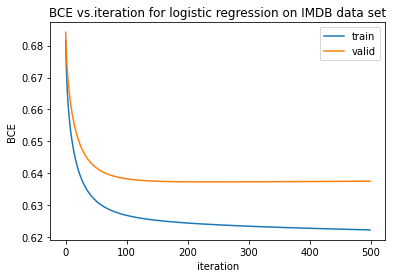

In [218]:
import matplotlib.pyplot as plt

plt.clf()
plt.plot(total_loss_train, label='train')
plt.plot(total_loss_valid, label='valid')
plt.xlabel('iteration')
plt.ylabel('BCE')
plt.title("BCE vs.iteration for logistic regression on IMDB data set")
plt.legend()
plt.show()

Obtain predictions for training, validation and test points for the IMDB data.

In [219]:
train_imdb_y_pred = logistic_regression.predict(train_imdb_x_dense)
val_imdb_y_pred = logistic_regression.predict(val_imdb_x_dense)
test_imdb_y_pred = logistic_regression.predict(test_imdb_x_dense)

##### Accuracy

Compute classification accuracy for the logistic regression.

In [220]:
train_imdb_pred = train_imdb_y_pred > 0.5
val_imdb_pred = val_imdb_y_pred > 0.5
test_imdb_pred = test_imdb_y_pred > 0.5

final_imdb_train_accuracy = EvaluationUtils.calculate_accuracy(train_imdb_pred, train_imdb_y)
final_imdb_valid_accuracy = EvaluationUtils.calculate_accuracy(val_imdb_pred, val_imdb_y)

print("IMDB training accuracy:", final_imdb_train_accuracy)
print("IMDB validation accuracy:", final_imdb_valid_accuracy)

IMDB training accuracy: 0.6345333333333333
IMDB validation accuracy: 0.6205


In [221]:
best_test_imdb_y_predict = logistic_regression.predict(test_imdb_x_dense, is_test=True)
best_test_imdb_predict = best_test_imdb_y_predict > 0.5

best_imdb_test_accuracy = EvaluationUtils.calculate_accuracy(best_test_imdb_predict, test_imdb_y)
print("Best IMDB test accuracy:", best_imdb_test_accuracy)

Best IMDB test accuracy: 0.62024


##### Loss

Compute BCE loss for logistic regression on IMDB data.

In [222]:
train_imdb_bce_loss = EvaluationUtils.calculate_bce_loss(train_imdb_y_pred, train_imdb_y)
val_imdb_bce_loss = EvaluationUtils.calculate_bce_loss(val_imdb_y_pred, val_imdb_y)

print("Training set BCE loss on IMDB data:", train_imdb_bce_loss)
print("Validation set BCE loss on IMDB data:", val_imdb_bce_loss)

Training set BCE loss on IMDB data: 0.6283169541465043
Validation set BCE loss on IMDB data: 0.6375078819930377


In [223]:
best_imdb_test_loss = EvaluationUtils.calculate_bce_loss(best_test_imdb_y_predict, test_imdb_y)
print("Best IMDB test loss:", best_imdb_test_loss)

Best IMDB test loss: 0.6393204299334188


##### AUROC and AUPRC

In [224]:
imdb_auroc = EvaluationUtils.calculate_roc_auc(best_test_imdb_y_predict, test_imdb_y)
print("IMDB AUROC when validation loss is lowest: {}".format(imdb_auroc))

IMDB AUROC when validation loss is lowest: 0.6729477504000001


In [225]:
imdb_auprc = EvaluationUtils.calculate_pr_auc(best_test_imdb_y_predict, test_imdb_y)
print("IMDB AUPRC when validation loss is lowest: {}".format(imdb_auprc))

IMDB AUPRC when validation loss is lowest: 0.6599699182098047


##### ROC curve and PR curve

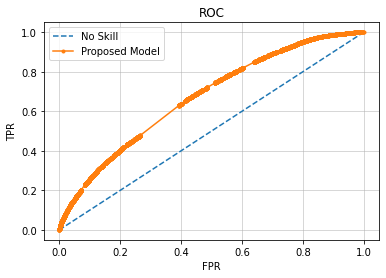

In [226]:
EvaluationUtils.plot_roc_curve(best_test_imdb_y_predict, test_imdb_y)

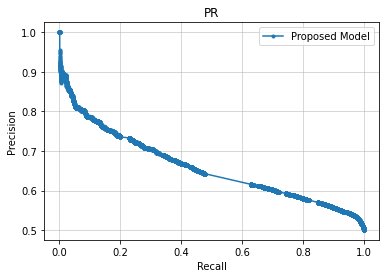

In [227]:
EvaluationUtils.plot_pr_curve(best_test_imdb_y_predict, test_imdb_y)

##### Confusion matrix

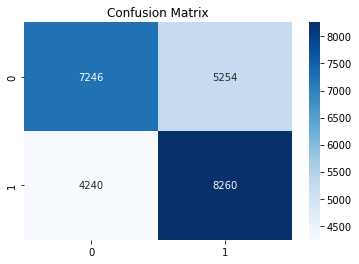

In [228]:
EvaluationUtils.plot_confusion_matrix(best_test_imdb_predict, test_imdb_y)

## Multiclass Regression

### Implementation

Define multiclass regression class

In [49]:
class MultinomialLogistic:
    def __init__(self, nFeatures, nClasses):
        self.W = np.random.rand(nFeatures, nClasses)
        self.best_model_weights = np.random.rand(nFeatures, nClasses)

    def predict(self, X, is_test=False):

        if is_test:
          y_pred = np.exp(np.matmul(X, self.best_model_weights))
        else:
          y_pred = np.exp(np.matmul(X, self.W))
        return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)

    def grad(self, X, y):
        return np.matmul(X.transpose(), self.predict(X) - y)

    def ce(self, X, y):
        return -np.sum(y * np.log(self.predict(X)))

    def fit(self, X, y, X_valid=None, y_valid=None, lr=0.1, niter=1000):
        losses_train = np.zeros(niter)
        losses_valid = np.zeros(niter)
        
        best_val_loss = float("inf")
        
        for i in range(niter):
            self.W = self.W - lr * self.grad(X, y)
            loss_train = self.ce(X, y)
            losses_train[i] = loss_train
            if X_valid is not None and y_valid is not None:
                loss_valid = self.ce(X_valid, y_valid)
                losses_valid[i] = loss_valid
                print(f"iter {i}: {loss_train:.3f}; {loss_valid:.3f}")

                if loss_valid < best_val_loss:
                  best_val_loss = loss_valid
                  self.best_model_weights = copy.deepcopy(self.W)

            else:
                print(f"iter {i}: {loss_train:.3f}")
        return losses_train, losses_valid

    def check_grad(self, X, y):
        N, C = y.shape
        D = X.shape[1]

        diff = np.zeros((D, C))

        W = self.W.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4

                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W

                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.grad(X, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()

        return diff.sum()

### Fitting the model

Instantiate model for news data

In [50]:
D = train_news_x.shape[1]
C = train_news_y.shape[1]

mlr = MultinomialLogistic(D, C)

Fitting the news data

In [51]:
train_news_y_array = train_news_y.toarray()
val_news_y_array = val_news_y.toarray()
test_news_y_array = test_news_y.toarray()

ce_train, ce_valid = mlr.fit(train_news_x, train_news_y_array, val_news_x, val_news_y_array)

iter 0: 2175.767; 700.084
iter 1: 1979.013; 637.494
iter 2: 1853.445; 597.397
iter 3: 1765.248; 569.290
iter 4: 1698.993; 548.284
iter 5: 1646.895; 531.873
iter 6: 1604.557; 518.627
iter 7: 1569.280; 507.664
iter 8: 1539.302; 498.405
iter 9: 1513.422; 490.459
iter 10: 1490.787; 483.546
iter 11: 1470.775; 477.464
iter 12: 1452.920; 472.061
iter 13: 1436.863; 467.223
iter 14: 1422.326; 462.859
iter 15: 1409.086; 458.898
iter 16: 1396.965; 455.284
iter 17: 1385.817; 451.969
iter 18: 1375.520; 448.917
iter 19: 1365.973; 446.095
iter 20: 1357.093; 443.476
iter 21: 1348.806; 441.038
iter 22: 1341.051; 438.761
iter 23: 1333.775; 436.630
iter 24: 1326.931; 434.630
iter 25: 1320.480; 432.749
iter 26: 1314.386; 430.975
iter 27: 1308.619; 429.299
iter 28: 1303.150; 427.713
iter 29: 1297.955; 426.210
iter 30: 1293.014; 424.782
iter 31: 1288.305; 423.424
iter 32: 1283.813; 422.131
iter 33: 1279.521; 420.898
iter 34: 1275.415; 419.720
iter 35: 1271.482; 418.594
iter 36: 1267.711; 417.516
iter 37: 12

Plot CE vs. iteration.

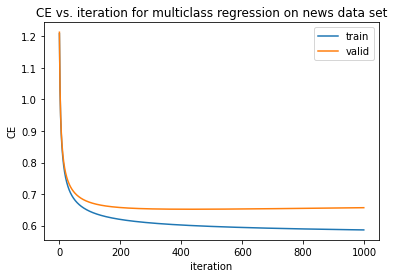

In [52]:
import matplotlib.pyplot as plt

plt.clf()
plt.plot(ce_train/train_news_x.shape[0], label='train')
plt.plot(ce_valid/val_news_x.shape[0], label='valid')
plt.xlabel('iteration')
plt.ylabel('CE')
plt.title("CE vs. iteration for multiclass regression on news data set")
plt.legend()
plt.show()

Obtain predictions for training, validation and test points for the news data.

In [53]:
train_news_y_pred = mlr.predict(train_news_x)
val_news_y_pred = mlr.predict(val_news_x)
test_news_y_pred = mlr.predict(test_news_x)

### Evaluate the model

Compute classification accuracy for the multiclass regression.

In [54]:
final_train_accuracy_mlr = EvaluationUtils.evaluate(train_news_y_array, train_news_y_pred)
final_valid_accuracy_mlr = EvaluationUtils.evaluate(val_news_y_array, val_news_y_pred)
final_test_accuracy_mlr = EvaluationUtils.evaluate(test_news_y_array, test_news_y_pred)

print("MLR news training accuracy:", final_train_accuracy_mlr)
print("MLR news validation accuracy:", final_valid_accuracy_mlr)
print("MLR news test accuracy:", final_test_accuracy_mlr)

MLR news training accuracy: 0.7544444444444445
MLR news validation accuracy: 0.708838821490468
MLR news test accuracy: 0.6902654867256637


In [55]:
best_test_accuracy = EvaluationUtils.evaluate(test_news_y_array, mlr.predict(test_news_x, is_test=True))
print("Best MLR test accuracy for news data:", best_test_accuracy)

Best MLR test accuracy for news data: 0.6934260429835651


Compute CE loss for multiclass regression on news data.

In [56]:
train_news_ce_loss = EvaluationUtils.calculate_ce_loss(train_news_y_pred, train_news_y_array)
val_news_ce_loss = EvaluationUtils.calculate_ce_loss(val_news_y_pred, val_news_y_array)
test_news_ce_loss = EvaluationUtils.calculate_ce_loss(test_news_y_pred, test_news_y_array)

print("Training set CE loss on news data:", train_news_ce_loss)
print("Validation set CE loss on news data:", val_news_ce_loss)
print("Test set CE loss on news data:", test_news_ce_loss)

Training set CE loss on news data: 0.5862605855405976
Validation set CE loss on news data: 0.6567673692238039
Test set CE loss on news data: 0.7340437364772027


## Comparison with KNN

### KNN for IMDB data

##### Implementation

In [57]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve,auc

Create KNN model and fit the IMDB data.

In [58]:
knn_imdb = KNeighborsClassifier()

knn_imdb.fit(train_imdb_x, np.ravel(train_imdb_y, order='C'))

y_pred_knn_imdb = knn_imdb.predict(test_imdb_x)

##### Accuracy

Compute classification accuracy for the logistic regression.

In [59]:
test_imdb_knn_pred = y_pred_knn_imdb > 0.5

acc_knn_imdb = EvaluationUtils.calculate_accuracy(test_imdb_knn_pred, test_imdb_y)

print("IMDB KNN test accuracy:", acc_knn_imdb)

IMDB KNN test accuracy: 0.5


##### Loss

Compute BCE loss for logistic regression on IMDB data.

In [60]:
loss_knn_imdb = EvaluationUtils.calculate_bce_loss(y_pred_knn_imdb, test_imdb_y)
print("IMDB KNN test loss:", loss_knn_imdb)

IMDB KNN test loss: 11.512925464921352


##### ROC and AUROC

Plot ROC curve for the KNN model on the IMDB data.

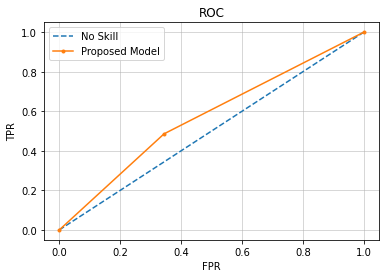

In [61]:
EvaluationUtils.plot_roc_curve(y_pred_knn_imdb, test_imdb_y)

Calculate AUROC for KNN model on the IMDB data.

In [62]:
auroc_knn_imdb = EvaluationUtils.calculate_roc_auc(y_pred_knn_imdb, test_imdb_y)
print("AUROC for KNN model on IMDB data:", auroc_knn_imdb)

AUROC for KNN model on IMDB data: 0.5709200000000001


##### PR and AUPRC

Plot PR curve for the KNN model on the IMDB data.

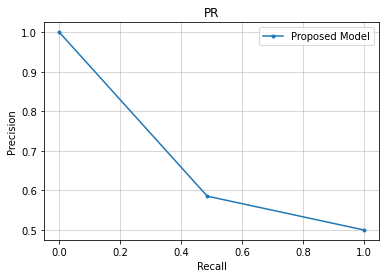

In [63]:
EvaluationUtils.plot_pr_curve(y_pred_knn_imdb, test_imdb_y)

Calculate AUPRC for KNN model on the IMDB data.

In [64]:
auprc_knn_imdb = EvaluationUtils.calculate_pr_auc(y_pred_knn_imdb, test_imdb_y)
print("AUPRC for KNN model on IMDB data: {}".format(auprc_knn_imdb))

AUPRC for KNN model on IMDB data: 0.6642264264379998


### KNN for news data with hyperparameter tuning

#### Implementation

Get the best k and distance function for the news data set.

In [65]:
# hyperparameter tuning
n_neighbors_news = list(range(1, 10))
p_news = [1, 2] # 1 = Manhattan, 2 = Euclidean
hyperparameters = dict(n_neighbors=n_neighbors_news, p=p_news)

knn_news = KNeighborsClassifier()
clf = GridSearchCV(knn_news, hyperparameters, cv=10)
best_model_news = clf.fit(train_news_x, train_news_y_array)

# get best k and distance function
news_best_k = best_model_news.best_estimator_.get_params()['n_neighbors']
news_best_p = best_model_news.best_estimator_.get_params()['p']
print('Best n_neighbors for news data:', news_best_k)
print('Best distance function for news data:', news_best_p)


Best n_neighbors for news data: 3
Best distance function for news data: 2


Create KNN model and fit the news data.

In [66]:
knn_news = KNeighborsClassifier(n_neighbors=news_best_k, p=news_best_p)

knn_news.fit(train_news_x, train_news_y_array)

y_pred_knn_news = knn_news.predict(test_news_x)

#### Prediction accuracy

Evaluate KNN prediction on the news data.

In [67]:
knn_news_test_accuracy = metrics.accuracy_score(test_news_y_array, y_pred_knn_news)
print("Accuracy:", knn_news_test_accuracy)

Accuracy: 0.6479140328697851


Get KNN loss on news data.

In [68]:
news_knn_loss = EvaluationUtils.calculate_ce_loss(y_pred_knn_news, test_news_y_array)
print("KNN loss on news data:", news_knn_loss)

KNN loss on news data: 8.107078993599455


# Task 3

### IMDB feature from the simple linear regression with z-scores

Report the top 10 features with most positive z-scores and top 10 features with the most negative z-scores on the IMDB data (calculated in Task 1).

In [69]:
z_scores_imdb_t = np.transpose(z_scores_imdb)

max_indices = np.argpartition(z_scores_imdb_t[0], -10)[-10:]
min_indices = np.argpartition(z_scores_imdb_t[0], 10)[:10]

Retrive words corresponding to these indices.

In [70]:
# retrieve vocab
with open("/content/aclImdb/imdb.vocab", encoding="utf8") as vocab:
  vocab = vocab.read()

vocab = np.array(vocab.split("\n"))

top_features = [*vocab[max_indices], *vocab[min_indices]]
top_zscores = [*z_scores_imdb[max_indices], *z_scores_imdb[min_indices]]
top_zscores = np.array(top_zscores)
top_zscores = np.concatenate(top_zscores, axis=0 )

Create horizontal bar plot for the z-scores.

Text(0.5, 0, 'Z-score')

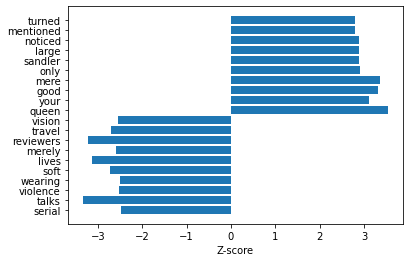

In [71]:
fig, ax = plt.subplots()

y_pos = np.arange(len(top_features))

ax.barh(y_pos, top_zscores, align='center')
plt.yticks(y_pos, top_features)
ax.invert_yaxis()
ax.set_xlabel("Z-score")

### IMDB feature from the logistic regression with the coefficient

Text(0.5, 0, 'coefficients')

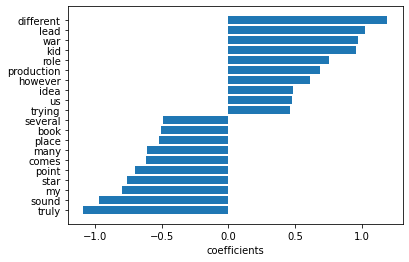

In [72]:
coefficients = logistic_regression.best_w[:,0]

most_negative_indices = coefficients.argsort()[:10]
most_negative_indices = most_negative_indices[::-1]
most_positive_indices = (-coefficients).argsort()[:10]
top_indices = np.append(most_positive_indices, most_negative_indices)

top_features_logistic = [*vocab[most_positive_indices], *vocab[most_negative_indices]]

top_coefficients = np.array([])
for i in top_indices:
  top_coefficients = np.append(top_coefficients, coefficients[i])

fig, ax = plt.subplots()
y_pos = np.arange(len(top_features_logistic))
ax.barh(y_pos, top_coefficients, align='center')
plt.yticks(y_pos, top_features_logistic)
ax.invert_yaxis()
ax.set_xlabel("coefficients")

### Binary classification on IMDB dataset

Refer to Task 2 / Logistic Regression.

### Multiclass classification on news dataset

Refer to Task 2 / Multiclass Regression.

### ROC of logistic regression and KNN on IMDB data.

Plot ROC curves for logistic regression and KNN on IMDB data.

We have plotted the ROC of both logistic regression and KNN on IMDB data separately in Task 2. Here is the plot containing two ROC curves of logistic regression and sklearn-KNN on the IMDB test data.

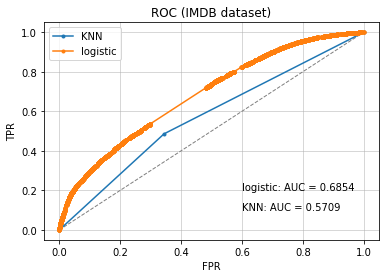

In [73]:
knn_fpr, knn_tpr, _ = roc_curve(test_imdb_y, y_pred_knn_imdb)
knn_auc = roc_auc_score(test_imdb_y, y_pred_knn_imdb)

logistic_fpr, logistic_tpr, _ = roc_curve(test_imdb_y, best_test_imdb_y_predict)
logistic_auc = roc_auc_score(test_imdb_y, best_test_imdb_y_predict)

plt.title("ROC (IMDB dataset)")
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN')
plt.plot(logistic_fpr, logistic_tpr, marker='.', label='logistic')
plt.text(0.6, 0.2, "logistic: AUC = " + str(round(logistic_auc,4)))
plt.text(0.6, 0.1, "KNN: AUC = " + str(round(knn_auc,4)))
plt.grid(linewidth=0.5)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()


### Accuracy comparison of the two models as a function of dataset size

#### Randomly sample portions of the data

In [74]:
n_imdb = train_imdb_x.shape[0]
n_news = train_news_x.shape[0]

# get random permutation of indices
perm_imdb = np.random.permutation(n_imdb)
# get corresponding percentage of the indices
train_imdb_x_20 = train_imdb_x[perm_imdb[:int(0.2 * n_imdb)]]
train_imdb_y_20 = train_imdb_y[perm_imdb[:int(0.2 * n_imdb)]]
train_imdb_x_dense_20 = train_imdb_x_20.toarray()

# repeat for all other percentages
# 40%
perm_imdb = np.random.permutation(n_imdb)
train_imdb_x_40 = train_imdb_x[perm_imdb[:int(0.4 * n_imdb)]]
train_imdb_y_40 = train_imdb_y[perm_imdb[:int(0.4 * n_imdb)]]
train_imdb_x_dense_40 = train_imdb_x_40.toarray()

# 60%
perm_imdb = np.random.permutation(n_imdb)
train_imdb_x_60 = train_imdb_x[perm_imdb[:int(0.6 * n_imdb)]]
train_imdb_y_60 = train_imdb_y[perm_imdb[:int(0.6 * n_imdb)]]
train_imdb_x_dense_60 = train_imdb_x_60.toarray()
# 80%
perm_imdb = np.random.permutation(n_imdb)
train_imdb_x_80 = train_imdb_x[perm_imdb[:int(0.8 * n_imdb)]]
train_imdb_y_80 = train_imdb_y[perm_imdb[:int(0.8 * n_imdb)]]
train_imdb_x_dense_80 = train_imdb_x_80.toarray()

# repeat for news set
# 20%
perm_news = np.random.permutation(n_news)
train_news_x_20 = train_news_x[perm_news[:int(0.2 * n_news)]]
train_news_y_20 = train_news_y[perm_news[:int(0.2 * n_news)]]
# 40%
perm_news = np.random.permutation(n_news)
train_news_x_40 = train_news_x[perm_news[:int(0.4 * n_news)]]
train_news_y_40 = train_news_y[perm_news[:int(0.4 * n_news)]]
# 60%
perm_news = np.random.permutation(n_news)
train_news_x_60 = train_news_x[perm_news[:int(0.6 * n_news)]]
train_news_y_60 = train_news_y[perm_news[:int(0.6 * n_news)]]
# 80%
perm_news = np.random.permutation(n_news)
train_news_x_80 = train_news_x[perm_news[:int(0.8 * n_news)]]
train_news_y_80 = train_news_y[perm_news[:int(0.8 * n_news)]]

#### Train and evaluate the datasets on both models

##### Logistic regression and KNN (IMDB dataset)

Get AUROC for logistic regression on IMDB set.

In [75]:
# 20%
logistic_20 = LogisticRegression()
logistic_20.fit(train_imdb_x_dense_20, train_imdb_y_20, 
                val_imdb_x_dense, val_imdb_y,
                batch_size=IMDB_BATCH_SIZE,
                learning_rate=IMDB_LR,
                niter=IMDB_EPOCHS)

best_test_imdb_y_predict_20 = logistic_20.predict(test_imdb_x_dense, is_test = True)
auroc_logistic_20 = EvaluationUtils.calculate_roc_auc(best_test_imdb_y_predict_20, test_imdb_y)

# 40%
logistic_40 = LogisticRegression()
logistic_40.fit(train_imdb_x_dense_40, train_imdb_y_40, 
                val_imdb_x_dense, val_imdb_y,
                batch_size=IMDB_BATCH_SIZE,
                learning_rate=IMDB_LR,
                niter=IMDB_EPOCHS)

best_test_imdb_y_predict_40 = logistic_40.predict(test_imdb_x_dense, is_test = True)
auroc_logistic_40 = EvaluationUtils.calculate_roc_auc(best_test_imdb_y_predict_40, test_imdb_y)

# 60%
logistic_60 = LogisticRegression()
logistic_60.fit(train_imdb_x_dense_60, train_imdb_y_60, 
                val_imdb_x_dense, val_imdb_y,
                batch_size=IMDB_BATCH_SIZE,
                learning_rate=IMDB_LR,
                niter=IMDB_EPOCHS)

best_test_imdb_y_predict_60 = logistic_60.predict(test_imdb_x_dense, is_test = True)
auroc_logistic_60 = EvaluationUtils.calculate_roc_auc(best_test_imdb_y_predict_60, test_imdb_y)

# 80%
logistic_80 = LogisticRegression()
logistic_80.fit(train_imdb_x_dense_80, train_imdb_y_80, 
                val_imdb_x_dense, val_imdb_y,
                batch_size=IMDB_BATCH_SIZE,
                learning_rate=IMDB_LR,
                niter=IMDB_EPOCHS)

best_test_imdb_y_predict_80 = logistic_80.predict(test_imdb_x_dense, is_test = True)
auroc_logistic_80 = EvaluationUtils.calculate_roc_auc(best_test_imdb_y_predict_80, test_imdb_y)




print("AUROC using 20% of IMDB training set for logestic regression:", auroc_logistic_20)
print("AUROC using 40% of news training set for logestic regression:", auroc_logistic_40)
print("AUROC using 60% of news training set for logestic regression:", auroc_logistic_60)
print("AUROC using 80% of news training set for logestic regression:", auroc_logistic_80)

Epoch: 0, train loss: 0.6675652186177928, validation loss: 0.6964640011320528
Epoch: 1, train loss: 0.6646568938065359, validation loss: 0.6941153603215858
Epoch: 2, train loss: 0.6618754266145296, validation loss: 0.6918935336096252
Epoch: 3, train loss: 0.6592137025418953, validation loss: 0.6897901647745477
Epoch: 4, train loss: 0.6566650838047744, validation loss: 0.6877975108594475
Epoch: 5, train loss: 0.6542233745312773, validation loss: 0.6859083977099512
Epoch: 6, train loss: 0.6518827883129585, validation loss: 0.6841161779102058
Epoch: 7, train loss: 0.6496379180308803, validation loss: 0.6824146912034339
Epoch: 8, train loss: 0.6474837078588692, validation loss: 0.6807982274210603
Epoch: 9, train loss: 0.6454154273352675, validation loss: 0.6792614918961657
Epoch: 10, train loss: 0.6434286473874965, validation loss: 0.6777995733006619
Epoch: 11, train loss: 0.6415192181902776, validation loss: 0.6764079138190869
Epoch: 12, train loss: 0.6396832487377302, validation loss: 0.

Get AUROC for KNN on IMDB set.

In [76]:
# 20%
knn_imdb_20 = KNeighborsClassifier()
knn_imdb_20.fit(train_imdb_x_20, np.ravel(train_imdb_y_20, order='C'))
y_pred_knn_imdb_20 = knn_imdb_20.predict(test_imdb_x)
auroc_knn_20 = EvaluationUtils.calculate_roc_auc(y_pred_knn_imdb_20, test_imdb_y)

# 40%
knn_imdb_40 = KNeighborsClassifier()
knn_imdb_40.fit(train_imdb_x_40, np.ravel(train_imdb_y_40, order='C'))
y_pred_knn_imdb_40 = knn_imdb_40.predict(test_imdb_x)
auroc_knn_40 = EvaluationUtils.calculate_roc_auc(y_pred_knn_imdb_40, test_imdb_y)

# 60%
knn_imdb_60 = KNeighborsClassifier()
knn_imdb_60.fit(train_imdb_x_60, np.ravel(train_imdb_y_60, order='C'))
y_pred_knn_imdb_60 = knn_imdb_60.predict(test_imdb_x)
auroc_knn_60 = EvaluationUtils.calculate_roc_auc(y_pred_knn_imdb_60, test_imdb_y)

# 80%
knn_imdb_80 = KNeighborsClassifier()
knn_imdb_80.fit(train_imdb_x_80, np.ravel(train_imdb_y_80, order='C'))
y_pred_knn_imdb_80 = knn_imdb_80.predict(test_imdb_x)
auroc_knn_80 = EvaluationUtils.calculate_roc_auc(y_pred_knn_imdb_80, test_imdb_y)

print("AUROC using 20% of IMDB training set for KNN:", auroc_knn_20)
print("AUROC using 40% of news training set for KNN:", auroc_knn_40)
print("AUROC using 60% of news training set for KNN:", auroc_knn_60)
print("AUROC using 80% of news training set for KNN:", auroc_knn_80)

AUROC using 20% of IMDB training set for KNN: 0.568
AUROC using 40% of news training set for KNN: 0.56388
AUROC using 60% of news training set for KNN: 0.56288
AUROC using 80% of news training set for KNN: 0.5696


Create bar plot for prediction accuracies of KNN and logistic regression on IMDB set.

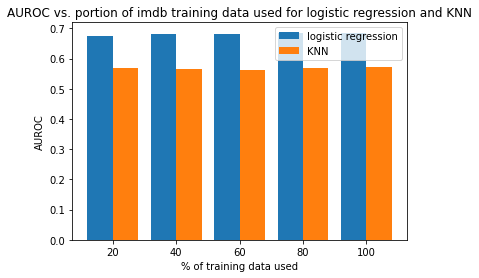

In [77]:
percentages = ["20", "40", "60", "80", "100"]
logistic_aurocs = [auroc_logistic_20, auroc_logistic_40, auroc_logistic_60, auroc_logistic_80, imdb_auroc]
knn_aurocs = [auroc_knn_20, auroc_knn_40, auroc_knn_60, auroc_knn_80, auroc_knn_imdb]

x_axis = np.arange(len(percentages))

plt.bar(x_axis - 0.2, logistic_aurocs, 0.4, label='logistic regression')
plt.bar(x_axis + 0.2, knn_aurocs, 0.4, label='KNN')

plt.xticks(x_axis, percentages)
plt.xlabel("% of training data used")
plt.ylabel("AUROC")
plt.title("AUROC vs. portion of imdb training data used for logistic regression and KNN")
plt.legend()
plt.show()

##### Multiclass regression and KNN (news dataset)

Get prediction accuracies for multiclass regression on news set.

In [78]:
# get prediction accuracies for multiclass regression
D = train_news_x_20.shape[1]
C = train_news_y_20.shape[1]

# 20%
mlr_20 = MultinomialLogistic(D, C)
train_news_y_20_array = train_news_y_20.toarray()
mlr_20.fit(train_news_x_20, train_news_y_20_array, val_news_x, val_news_y_array)
test_news_y_pred_20 = mlr_20.predict(test_news_x)
mlr_test_acc_20 = EvaluationUtils.evaluate(test_news_y_pred_20, test_news_y_array)

# 40%
mlr_40 = MultinomialLogistic(D, C)
train_news_y_40_array = train_news_y_40.toarray()
mlr_40.fit(train_news_x_40, train_news_y_40_array, val_news_x, val_news_y_array)
test_news_y_pred_40 = mlr_40.predict(test_news_x)
mlr_test_acc_40 = EvaluationUtils.evaluate(test_news_y_pred_40, test_news_y_array)

# 60%
mlr_60 = MultinomialLogistic(D, C)
train_news_y_60_array = train_news_y_60.toarray()
mlr_60.fit(train_news_x_60, train_news_y_60_array, val_news_x, val_news_y_array)
test_news_y_pred_60 = mlr_60.predict(test_news_x)
mlr_test_acc_60 = EvaluationUtils.evaluate(test_news_y_pred_60, test_news_y_array)

# 80%
mlr_80 = MultinomialLogistic(D, C)
train_news_y_80_array = train_news_y_80.toarray()
mlr_80.fit(train_news_x_80, train_news_y_80_array, val_news_x, val_news_y_array)
test_news_y_pred_80 = mlr_80.predict(test_news_x)
mlr_test_acc_80 = EvaluationUtils.evaluate(test_news_y_pred_80, test_news_y_array)


print("Prediction accuracy using 20% of news training set for MLR:", mlr_test_acc_20)
print("Prediction accuracy using 40% of news training set for MLR:", mlr_test_acc_40)
print("Prediction accuracy using 60% of news training set for MLR:", mlr_test_acc_60)
print("Prediction accuracy using 80% of news training set for MLR:", mlr_test_acc_80)

iter 0: 484.711; 778.964
iter 1: 470.057; 757.966
iter 2: 456.790; 738.810
iter 3: 444.832; 721.401
iter 4: 434.076; 705.607
iter 5: 424.396; 691.274
iter 6: 415.666; 678.247
iter 7: 407.767; 666.378
iter 8: 400.591; 655.529
iter 9: 394.044; 645.579
iter 10: 388.045; 636.423
iter 11: 382.524; 627.968
iter 12: 377.424; 620.134
iter 13: 372.693; 612.854
iter 14: 368.290; 606.067
iter 15: 364.177; 599.723
iter 16: 360.325; 593.777
iter 17: 356.707; 588.191
iter 18: 353.298; 582.931
iter 19: 350.080; 577.966
iter 20: 347.034; 573.272
iter 21: 344.146; 568.826
iter 22: 341.402; 564.606
iter 23: 338.790; 560.595
iter 24: 336.300; 556.776
iter 25: 333.921; 553.135
iter 26: 331.646; 549.659
iter 27: 329.468; 546.337
iter 28: 327.378; 543.157
iter 29: 325.372; 540.110
iter 30: 323.443; 537.188
iter 31: 321.587; 534.381
iter 32: 319.799; 531.684
iter 33: 318.075; 529.089
iter 34: 316.410; 526.590
iter 35: 314.802; 524.182
iter 36: 313.247; 521.859
iter 37: 311.743; 519.617
iter 38: 310.286; 517.

Get prediction accuracies for KNN on news set.

In [79]:
# 20%
knn_news_20 = KNeighborsClassifier(n_neighbors=news_best_k, p=news_best_p)
knn_news_20.fit(train_news_x_20, train_news_y_20_array)
y_pred_knn_news_20 = knn_news_20.predict(test_news_x)
knn_news_test_acc_20 = EvaluationUtils.evaluate(y_pred_knn_news_20, test_news_y_array)

# 40%
knn_news_40 = KNeighborsClassifier(n_neighbors=news_best_k, p=news_best_p)
knn_news_40.fit(train_news_x_40, train_news_y_40_array)
y_pred_knn_news_40 = knn_news_40.predict(test_news_x)
knn_news_test_acc_40 = EvaluationUtils.evaluate(y_pred_knn_news_40, test_news_y_array)

# 60%
knn_news_60 = KNeighborsClassifier(n_neighbors=news_best_k, p=news_best_p)
knn_news_60.fit(train_news_x_60, train_news_y_60_array)
y_pred_knn_news_60 = knn_news_60.predict(test_news_x)
knn_news_test_acc_60 = EvaluationUtils.evaluate(y_pred_knn_news_60, test_news_y_array)

# 80%
knn_news_80 = KNeighborsClassifier(n_neighbors=news_best_k, p=news_best_p)
knn_news_80.fit(train_news_x_80, train_news_y_80_array)
y_pred_knn_news_80 = knn_news_80.predict(test_news_x)
knn_news_test_acc_80 = EvaluationUtils.evaluate(y_pred_knn_news_80, test_news_y_array)

print("Prediction accuracy using 20% of news training set for KNN:", knn_news_test_acc_20)
print("Prediction accuracy using 40% of news training set for KNN:", knn_news_test_acc_40)
print("Prediction accuracy using 60% of news training set for KNN:", knn_news_test_acc_60)
print("Prediction accuracy using 80% of news training set for KNN:", knn_news_test_acc_80)

Prediction accuracy using 20% of news training set for KNN: 0.6061946902654868
Prediction accuracy using 40% of news training set for KNN: 0.5891276864728192
Prediction accuracy using 60% of news training set for KNN: 0.5859671302149179
Prediction accuracy using 80% of news training set for KNN: 0.6466498103666245


Create bar plot for prediction accuracies of KNN and MLR on news set.

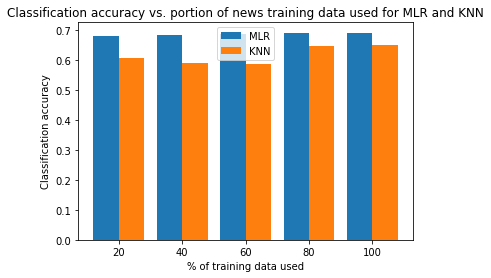

In [80]:
percentages = ["20", "40", "60", "80", "100"]
mlr_accuracies = [mlr_test_acc_20, mlr_test_acc_40, mlr_test_acc_60, mlr_test_acc_80, final_test_accuracy_mlr]
knn_accuracies = [knn_news_test_acc_20, knn_news_test_acc_40, knn_news_test_acc_60, knn_news_test_acc_80, knn_news_test_accuracy]

x_axis = np.arange(len(percentages))

plt.bar(x_axis - 0.2, mlr_accuracies, 0.4, label='MLR')
plt.bar(x_axis + 0.2, knn_accuracies, 0.4, label='KNN')

plt.xticks(x_axis, percentages)
plt.xlabel("% of training data used")
plt.ylabel("Classification accuracy")
plt.title("Classification accuracy vs. portion of news training data used for MLR and KNN")
plt.legend()
plt.show()

### News feature analysis

Get top 5 most positive features for the 4 classes chosen for MLR.

In [81]:
top_feature_idx = []

mlr_w = mlr.best_model_weights
pos_w = mlr_w * (mlr_w > 0)
for i in range(4):
    weights_per_class = pos_w[:,i]
    sort_idx = np.argsort(weights_per_class, axis=0)
    top_five_idx = sort_idx[-5:][::-1]
    top_five_weights = weights_per_class[top_five_idx]
    top_five_weights = top_five_weights
    top_feature_idx.append(top_five_idx)
    print("Top five index: {}, top five weights: {}".format(top_five_idx, top_five_weights))

top_feature_idx = np.asarray(top_feature_idx)
top_feature_idx = top_feature_idx.flatten()
print(top_feature_idx)

Top five index: [21 14  0 35 44], top five weights: [26.21392882 21.54340581 21.10486    14.16735782 12.60184512]
Top five index: [45 23 49 40 16], top five weights: [25.9906801  20.20273669 18.41865529 18.26105463 16.85428756]
Top five index: [11 27  3 20 29], top five weights: [24.8528732  22.08571716 11.05494289  9.52734642  9.43353242]
Top five index: [18  8  7 24  6], top five weights: [29.55511242 21.78624961 21.50607204 21.27335252 21.09386908]
[21 14  0 35 44 45 23 49 40 16 11 27  3 20 29 18  8  7 24  6]


In [82]:
feature_importance_heatmap = np.zeros((20, 4))

for i in range(20):

    feature_idx = top_feature_idx[i]
    for class_idx in range(4):
        weights = mlr_w[feature_idx, class_idx]
        feature_importance_heatmap[i, class_idx] = weights
        print("Feature idx: {}, class idx: {}, weights: {}".format(feature_idx, class_idx, weights))

Feature idx: 21, class idx: 0, weights: 26.213928822510812
Feature idx: 21, class idx: 1, weights: -9.148341432581221
Feature idx: 21, class idx: 2, weights: -5.05708599757651
Feature idx: 21, class idx: 3, weights: -8.915067870043977
Feature idx: 14, class idx: 0, weights: 21.54340581097191
Feature idx: 14, class idx: 1, weights: -5.753119550004974
Feature idx: 14, class idx: 2, weights: -6.679576140748544
Feature idx: 14, class idx: 3, weights: -6.375975591322347
Feature idx: 0, class idx: 0, weights: 21.10485999549592
Feature idx: 0, class idx: 1, weights: -6.495386232603943
Feature idx: 0, class idx: 2, weights: -6.480834960669149
Feature idx: 0, class idx: 3, weights: -5.874434509242733
Feature idx: 35, class idx: 0, weights: 14.167357815652231
Feature idx: 35, class idx: 1, weights: -10.655940586625588
Feature idx: 35, class idx: 2, weights: 3.2840292848381716
Feature idx: 35, class idx: 3, weights: -4.2922373292541245
Feature idx: 44, class idx: 0, weights: 12.601845120728864
Fe

In [83]:
print(feature_importance_heatmap)

[[ 26.21392882  -9.14834143  -5.057086    -8.91506787]
 [ 21.54340581  -5.75311955  -6.67957614  -6.37597559]
 [ 21.10486     -6.49538623  -6.48083496  -5.87443451]
 [ 14.16735782 -10.65594059   3.28402928  -4.29223733]
 [ 12.60184512  -8.86621558   7.55971412  -9.88572864]
 [ -7.23840741  25.9906801   -8.85585801  -8.07132865]
 [ -6.24835259  20.20273669  -6.37297951  -5.0144612 ]
 [ -4.93936094  18.41865529  -5.94672559  -5.25088956]
 [ -5.90657829  18.26105463  -5.02339763  -5.1496084 ]
 [  2.31213919  16.85428756 -10.42188632  -7.02071507]
 [ -8.91936802  -8.51731714  24.8528732   -6.11883418]
 [ -7.10154097  -5.1850378   22.08571716  -7.55013055]
 [ -3.87260178  -3.21352682  11.05494289  -2.93195236]
 [  1.46872384  -3.58063158   9.52734642  -4.93349708]
 [ -6.66545568  -4.84462151   9.43353242   4.3081952 ]
 [ -6.64162811  -5.21525141 -15.07093686  29.55511242]
 [ -6.55130466  -5.27655777  -7.25141491  21.78624961]
 [ -6.17307044  -4.85409359  -9.03861593  21.50607204]
 [ -5.6867

Text(69.0, 0.5, 'Feature Index')

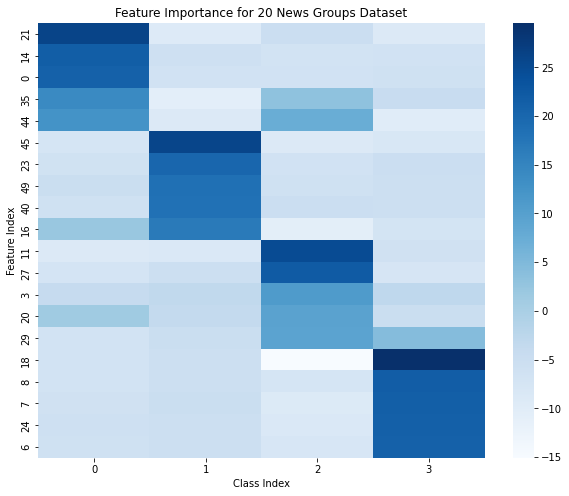

In [84]:
plt.figure(figsize=(10, 8))
plt.title("Feature Importance for 20 News Groups Dataset")
ax = sn.heatmap(feature_importance_heatmap, fmt='g', cmap='Blues')
ax.set_yticklabels(top_feature_idx)
plt.xlabel("Class Index")
plt.ylabel("Feature Index")

# BERT (Creative Point)

Note: Because of the limitation of GPU memory on Colab, we trained the BERT model on <font color='red'>MILA clusters</font>, and copied-pasted the result here. Please run the cells <font color='red'>**before**</font> the BERT model!

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 27.8 MB/s 
     |████████████████████████████████| 163 kB 73.7 MB/s 
     |████████████████████████████████| 7.6 MB 64.7 MB/s 


In [ ]:
bert_train_news_x, bert_val_news_x = processed_train_news_x[:1800], processed_train_news_x[1800:]
bert_train_news_y, bert_val_news_y = processed_train_news_y[:1800], processed_train_news_y[1800:]
bert_test_news_x, bert_test_news_y = processed_test_news_x, processed_test_news_y

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_input = tokenizer(processed_train_news_x, 
                       padding=True, 
                       truncation=True,
                       return_tensors="pt")
print(tokenizer.decode(bert_input.input_ids[0]))

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

[CLS] true dermatologists gave reached laser age fact lasers dermatological surgery new exciting field probably wont effective tinea pedis laser usually superficial burn avoid deeper damage limited tinea pedis cured albeit sometimes slowly topical antifungals well systemic medication ie tablets finally selfdiagnosis always reliable lichen simplex chronicus look like fungal infection requires different treatment [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class NewsDataset(Dataset):

    def __init__(self, x, y):

        self._y = y
        self._x = [tokenizer(doc, 
                             padding='max_length',
                             max_length=512,
                             truncation=True,
                             return_tensors="pt") for doc in x]

    def classes(self):
        return self._y

    def __len__(self):
        return len(self._y)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self._y[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self._x[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
bert_train_dataset = NewsDataset(bert_train_news_x, bert_train_news_y)
bert_val_dataset = NewsDataset(bert_val_news_x, bert_val_news_y)
bert_test_dataset = NewsDataset(bert_test_news_x, bert_test_news_y)

bert_train_data_loader = DataLoader(bert_train_dataset, batch_size=BERT_BATCH_SIZE)
bert_val_data_loader = DataLoader(bert_val_dataset, batch_size=BERT_BATCH_SIZE)
bert_test_data_loader = DataLoader(bert_test_dataset, batch_size=BERT_BATCH_SIZE)

### BERT Model

In [ ]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):


    def __init__(self, dropout=0.3):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 4)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids=input_id, 
                                     attention_mask=mask,
                                     return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

### Train

In [ ]:
from torch.optim import Adam
from tqdm import tqdm

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

bert_model = BertClassifier()
bert_model = bert_model.to(device)
bert_optimizer = Adam(bert_model.parameters(), lr=BERT_LR)

criterion = nn.CrossEntropyLoss()

train_loss_history, val_loss_history = [], []
train_acc_history, val_acc_history = [], []

best_model_weights = None
best_val_loss = float("inf")

for epoch in range(BERT_EPOCHS):

    # Train
    total_loss_train = 0
    total_acc_train = 0

    for train_input, train_label in tqdm(bert_train_data_loader):

        train_label = train_label.to(device)
        mask = train_input['attention_mask'].to(device)
        input_id = train_input['input_ids'].squeeze(1).to(device)

        output = bert_model(input_id, mask)
        
        batch_loss = criterion(output, train_label.long())
        total_loss_train += batch_loss.item()
        
        acc = (output.argmax(dim=1) == train_label).sum().item()
        total_acc_train += acc

        bert_model.zero_grad()
        batch_loss.backward()
        bert_optimizer.step()

    total_loss_train /= len(bert_train_data_loader)
    total_acc_train /= len(bert_train_data_loader)

    train_loss_history.append(total_loss_train)
    train_acc_history.append(total_acc_train)

    # Validation
    total_loss_val = 0
    total_acc_val = 0

    with torch.no_grad():

        for val_input, val_label in tqdm(bert_val_data_loader):

            val_label = val_label.to(device)
            mask = val_input['attention_mask'].to(device)
            input_id = val_input['input_ids'].squeeze(1).to(device)

            output = bert_model(input_id, mask)

            batch_loss = criterion(output, val_label.long())
            total_loss_val += batch_loss.item()
            
            acc = (output.argmax(dim=1) == val_label).sum().item()
            total_acc_val += acc

    total_loss_val /= len(bert_val_data_loader)
    total_acc_val /= len(bert_val_data_loader)

    val_loss_history.append(total_loss_val)
    val_acc_history.append(total_acc_val)

    if total_loss_val < best_val_loss:
        best_val_loss = total_loss_val
        bert_model_weights = bert_model.state_dict()
        best_model_weights = copy.deepcopy(bert_model_weights)

    print("Epoch: {}, train loss: {}, train acc: {}, val loss: {}, val acc: {}".format(epoch, total_loss_train, total_acc_train, total_loss_val, total_acc_val))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  2%|▏         | 2/113 [00:03<03:40,  1.98s/it]


KeyboardInterrupt: ignored

### Evaluate

We select the best model with the lowest validation loss, and test it on test dataset

In [ ]:
best_model = BertClassifier()
best_model = best_model.to(device)
best_model.load_state_dict(best_model_weights)

In [ ]:
total_loss_test = 0
total_acc_test = 0

# Test
with torch.no_grad():

    for test_input, test_label in tqdm(bert_test_data_loader):

        test_label = test_label.to(device)
        mask = test_input['attention_mask'].to(device)
        input_id = test_input['input_ids'].squeeze(1).to(device)

        output = best_model(input_id, mask)

        batch_loss = criterion(output, test_label.long())
        total_loss_test += batch_loss.item()

        acc = (output.argmax(dim=1) == test_label).sum().item()
        total_acc_test += acc

total_loss_test /= len(bert_test_data_loader)
total_acc_test /= len(bert_test_data_loader)

In [ ]:
print("Test loss: {}, test acc: {}".format(total_loss_test, total_acc_test))

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.title("BERT Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"])
# plt.show()
plt.savefig('bert_loss_curve.png')
plt.close()

In [ ]:
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.title("BERT Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"])
# plt.show()
plt.savefig('bert_acc_curve.png')
plt.close()

Here are the results we trained and evaluated on <font color="red">MILA clusters</font>

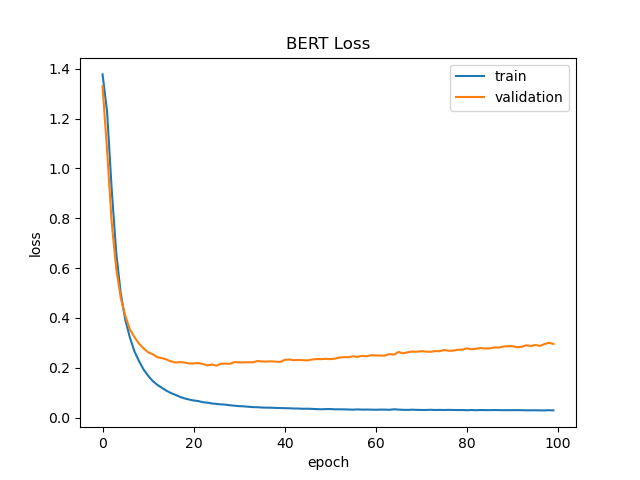

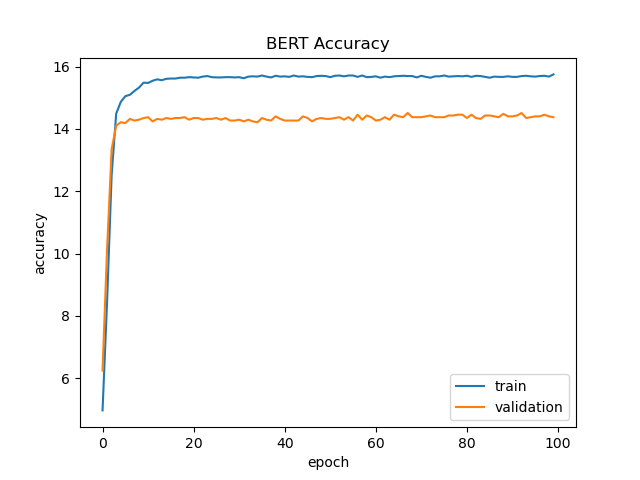

The test loss and accuracy (on test dataset) for the best BERT model (selected when the validataion loss is the lowest):

**Test loss: 0.21329823612338966, test acc: 14.88888888888889**

Further, the log when training and evaluating BERT model can be downloaded below:

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1XGgPZaDeea0PGEeNGcPc4hsQjTTcqGjj' -O bert.log